In [802]:
# import standard libraries
from sklearn.utils.validation import check_array, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


class kdn():
    def __init__(
        self,
        network,
        k=1,
        polytope_compute_method="all",
        weighting_method="lin",
        T=2,
        c=1,
        verbose=True,
    ):
        """Kernel Density Network

        Parameters
        ----------
        network : Keras Model
            trained neural network model
        k : int, optional
            bias tuning parameter, by default 1
        polytope_compute_method : str, optional
            select the polytope compute method, by default 'all'
        T : int, optional
            polytope size threshold, by default 2
        c : int, optional
            weight tuning parameter, by default 1
        weighting : bool, optional
            select the weighting scheme, by default True
        verbose : bool, optional
            display meta data, by default True
        """

        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.k = k
        self.c = c
        self.polytope_compute_method = polytope_compute_method
        self.T = T
        self.weighting_method = weighting_method
        self.bias = {}
        self.verbose = verbose

        # total number of layers in the NN
        self.total_layers = len(self.network.layers)

        # get the layer sizes of each layer
        self.network_shape = []
        for layer in network.layers:
            self.network_shape.append(layer.output_shape[-1])

        # get the weights and biases of the trained MLP
        self.weights = {}
        self.biases = {}
        for i in range(len(self.network.layers)):
            weight, bias = self.network.layers[i].get_weights()
            self.weights[i], self.biases[i] = weight, bias.reshape(1, -1)

    def _get_polytope_memberships(self, X):
        r"""
        Obtain the polytope ID of each input sample
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        polytope_memberships = []
        last_activations = X

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in range(self.total_layers):
            weights, bias = self.network.layers[layer_id].get_weights()

            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias

            # get list of activated nodes in this layer
            if layer_id == self.total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype("int")
            else:
                binary_preactivation = (preactivation > 0).astype("int")

            if self.polytope_compute_method == "pl":
                # determine the polytope memberships only based on the penultimate layer (uncomment )
                if layer_id == self.total_layers - 2:
                    polytope_memberships.append(binary_preactivation)

            if self.polytope_compute_method == "all":
                # determine the polytope memberships only based on all the FC layers (uncomment)
                if layer_id < self.total_layers - 1:
                    polytope_memberships.append(binary_preactivation)

            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation

        # Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis=1)
        polytope_memberships = [
            np.tensordot(
                polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes=1
            )
        ]

        self.num_fc_neurons = polytope_obs.shape[
            1
        ]  # get the number of total FC neurons under consideration

        return polytope_memberships

    def _get_activation_pattern(self, polytope_id):
        """get the ReLU activation pattern given the polytope ID

        Parameters
        ----------
        polytope_id : int
            polytope identifier

        Returns
        -------
        ndarray
            ReLU activation pattern (binary) corresponding to the given polytope ID
        """
        binary_string = np.binary_repr(polytope_id, width=self.num_fc_neurons)[::-1]
        return np.array(list(binary_string)).astype("int")

    def unit_step(self, x):
        """Computes the unit step function output for a given input

        Parameters
        ----------
        x : ndarray
            Input array

        Returns
        -------
        ndarray
            Unit step function output of the input array
        """
        x = np.maximum(x, 0)
        x[x > 0] = 1
        return x

    # def compute_weights(self, X_, X_ref, polytope_id):
    #     """compute weights based on the global network linearity measure

    #     Parameters
    #     ----------
    #     X_ : ndarray
    #         Input data matrix
    #     polytope_id : int
    #         refernce polytope identifier

    #     Returns
    #     -------
    #     ndarray
    #         weights of each input sample in the input data matrix
    #     """
    #     M_ref = self._get_activation_pattern(polytope_id)

    #     start = 0
    #     for l in range(len(self.network_shape) - 1):
    #         if l == 0:
    #             W = self.weights[l]
    #             B = self.biases[l]
    #         else:
    #             end = start + self.network_shape[l - 1]
    #             M_l = M_ref[start:end]
    #             start = end
    #             W = W @ np.diag(M_l) @ self.weights[l]
    #             B = B @ np.diag(M_l) @ self.weights[l] + self.biases[l]

    #     A_ref = X_ref @ W + B
    #     A = X_ @ W + B

    #     return np.exp(-self.c * np.linalg.norm(A - A_ref, axis=1, ord=2)**2)

    def compute_weights(self, X_, polytope_id):
        """compute weights based on the global network linearity measure

        Parameters
        ----------
        X_ : ndarray
            Input data matrix
        polytope_id : int
            refernce polytope identifier

        Returns
        -------
        ndarray
            weights of each input sample in the input data matrix
        """
        
        M_ref = model_kdn._get_activation_pattern(polytope_id)

        start = 0
        A = X_
        A_ref = X_
        d = 0
        for l in range(len(self.network_shape)-1):
            end = start + self.network_shape[l]
            M_l = M_ref[start:end]
            start = end
            W, B = self.weights[l], self.biases[l]
            pre_A = A @ W + B
            A = np.maximum(0, pre_A)
            pre_A_ref = A_ref @ W + B
            A_ref = pre_A_ref @ np.diag(M_l) 
            d += np.linalg.norm(A - A_ref, axis=1, ord=2)

        # return 1/( 1 + np.linalg.norm(A - A_ref, axis=1, ord=1))
        scales = np.exp(-self.c * d)
        return scales

    def fit(self, X, y):
        r"""
        Fits the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        X, y = check_X_y(X, y)
        self.labels = np.unique(y)

        feature_dim = X.shape[1]

        for label in self.labels:
            self.polytope_means[label] = []
            self.polytope_cov[label] = []

            X_ = X[np.where(y == label)[0]]
            polytope_memberships = self._get_polytope_memberships(X_)[0]
            unique_polytope_ids = np.unique(
                polytope_memberships
            )  # get the unique polytopes

            if self.verbose:
                print("Number of Polytopes : ", len(polytope_memberships))
                print("Number of Unique Polytopes : ", len(unique_polytope_ids))

            polytope_member_count = []  # store the polytope member counts

            for (
                idx
            ) in range(
                len(polytope_memberships)
            ):  # fit Gaussians for each unique non-singleton polytopes

                if self.weighting_method == "lin":
                    # compute weights of the input data samples w.r.t reference polytope
                    weights = self.compute_weights(X_, polytope_memberships[idx])
                elif self.weighting_method == "fm":
                    ########### FM (will be depricated) ################
                    a_native = self._get_activation_pattern(polytope_id)
                    weights = []
                    for member_polytope_id in polytope_memberships:
                        a_foreign = self._get_activation_pattern(member_polytope_id)

                        match_status = a_foreign == a_native
                        match_status = match_status.astype("int")

                        if len(np.where(match_status == 0)[0]) == 0:
                            weight = 1.0
                        else:
                            first_mismatch_idx = np.where(match_status == 0)[0][0]
                            weight = first_mismatch_idx / self.num_fc_neurons

                        weights.append(weight)
                    weights = np.array(weights)
                ########### FM (will be depricated) ################
                else:
                    weights = np.zeros((X_.shape[0],))
                    weights[polytope_memberships == polytope_id] = 1

                weights[weights < 1e-3] = 0  # set very small weights to zero

                idx = np.where(weights > 0)[0]

                polytope_size = len(idx)
                polytope_member_count.append(polytope_size)

                if (
                    polytope_size < self.T
                ):  # eliminate polytopes with too few samples within
                    continue

                scales = weights[idx] / np.max(weights[idx])

                # apply weights to the data
                X_tmp = X_[idx].copy()
                polytope_mean_ = np.average(
                    X_tmp, axis=0, weights=scales
                )  # compute the weighted average of the samples
                X_tmp -= polytope_mean_  # center the data

                sqrt_scales = np.sqrt(scales).reshape(-1, 1) @ np.ones(
                    feature_dim
                ).reshape(1, -1)
                X_tmp *= sqrt_scales  # scale the centered data with the square root of the weights

                # compute the covariance matrix of the underlying Gaussian using Ledoit-Wolf estimator

                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(scales) / sum(scales)

                # store the mean and covariances
                self.polytope_means[label].append(polytope_mean_)
                self.polytope_cov[label].append(polytope_cov_)

            ## calculate bias for each label
            likelihoods = np.zeros((np.size(X_, 0)), dtype=float)

            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods += np.nan_to_num(self._compute_pdf(X_, label, polytope_idx))

            likelihoods /= X_.shape[0]
            self.bias[label] = np.min(likelihoods) / (self.k * X_.shape[0])

            if self.verbose:
                plt.hist(polytope_member_count, bins=30)
                plt.xlabel("Number of Members")
                plt.ylabel("Number of Polytopes")
                plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        """compute the likelihood for the given data

        Parameters
        ----------
        X : ndarray
            Input data matrix
        label : int
            class label
        polytope_idx : int
            polytope identifier

        Returns
        -------
        ndarray
            likelihoods
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, cov=polytope_cov, allow_singular=True
        )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros((np.size(X, 0), len(self.labels)), dtype=float)

        for ii, label in enumerate(self.labels):
            total_polytopes = len(self.polytope_means[label])
            for polytope_idx, _ in enumerate(self.polytope_means[label]):
                likelihoods[:, ii] += np.nan_to_num(
                    self._compute_pdf(X, label, polytope_idx)
                )

            likelihoods[:, ii] = likelihoods[:, ii] / total_polytopes
            likelihoods[:, ii] += min(self.bias.values())

        proba = (likelihoods.T / (np.sum(likelihoods, axis=1) + 1e-100)).T
        return proba

    def predict_proba_nn(self, X):
        r"""
        Calculate posteriors using the vanilla NN
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        proba = self.network.predict(X)
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [810]:
import numpy as np
from sklearn.datasets import make_blobs
from numpy.random import uniform, normal, shuffle

import matplotlib.pyplot as plt
import seaborn as sns

def _clean_Xy(X, y):
    """
    Remove first junk index from X and y and randomly shuffle the entries.
    Parameters
    ----------
    X : array of shape [n_samples+1, x]
        The generated samples.
    y : array of shape [n_samples+1]
        The integer labels for cluster membership of each sample.
    Returns
    -------
    X : array of shape [n_samples, x]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    index = np.arange(1, y.size)
    shuffle(index)
    return (X[index, :], y[index])


def generate_ellipse(
    n_samples,
    width=(1, 0.75),
    height=None,
    offsets=None,
    sigma=0.1,
    random_state=None,
):
    """
    Generate axis-aligned ellipse simulation.
    (Categorization between ellipses)
    Parameters
    ----------
    n_samples : int
        Total number of points in simulation, evenly divided between ellipses.
    width : ndarray-like of shape [n_ellipses, 2], optional (default=(1, 0.75))
        Width of ellipses, measured from the origin to right bound.
        width and height must be able to be broadcasted to the same size.
    height : ndarray-like of shape [n_ellipses, 2], optional (default=None)
        Height of ellipses, measured from the origin to upper bound.
        width and height must be able to be broadcasted to the same size.
        If None, height=width(concentric circles simulation)
    offsets : ndarray-like of shape [n_ellipses, 2], optional (default=None)
        Centers of the ellipses.
        If None, all ellipses are centered at (0, 0)
    sigma : float, optional (default=0.1)
        Parameter controlling the width of the shapes.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    X : array of shape [n_samples, 2]
        The generated samples.
    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.
    """
    if random_state is None:
        np.random.seed(random_state)

    width = np.asarray(width)
    if height is None:
        height = width
    elif type(height) == int or type(height) == float:
        height = np.ones_like(width) * height
    else:
        height = np.asarray(height)
    if offsets is not None:
        offsets = np.asarray(offsets)

    n_ellipses = width.size

    X = np.empty((1, 2))
    y = np.array(1)
    for n in range(n_ellipses):
        size = n_samples / n_ellipses
        if type(size) == float:
            size = int(size)
            if n == n_ellipses:
                size = size + 1

        t = uniform(0, 2 * np.pi, size)
        a = width[n] + normal(0, sigma, size)
        b = height[n] + normal(0, sigma, size)

        xn = np.column_stack((a * np.cos(t), b * np.sin(t)))
        if offsets is not None:
            xn = xn + offsets[n, :]

        X = np.append(X, xn, axis=0)
        y = np.append(y, np.ones(size, dtype=int) * n)

    X, y = _clean_Xy(X, y)
    return (X, y)


In [811]:
from tensorflow import keras
from kdg.utils import generate_spirals
import seaborn as sns

In [597]:
# create training, validation, and testing data
X, y = generate_spirals(10000, noise=0.8, n_class=2)

X_val, y_val = generate_spirals(500, noise=0.8, n_class=2)

X_test, y_test = generate_spirals(1000, noise=0.8, n_class=2)

In [598]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [599]:
# define the network architecture
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [600]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Epoch 00188: early stopping


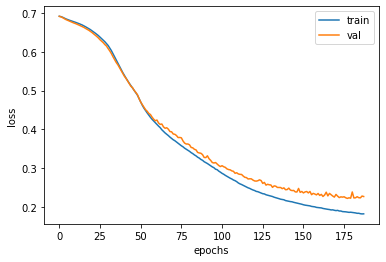

In [601]:
# plot the training loss and validation loss
fig, ax = plt.subplots()
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(["train", "val"])

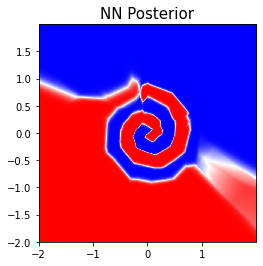

In [602]:
# plot the NN posterior
p = np.arange(-2, 2, step=0.005)
q = np.arange(-2, 2, step=0.005)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

proba_nn = nn.predict(grid_samples)

fig, ax = plt.subplots()
ax1 = ax.imshow(
        proba_nn[:, 0].reshape(800, 800).T,
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        cmap="bwr",
        vmin=0,
        vmax=1,
        interpolation="nearest",
        aspect="auto",
    )
ax.set_title("NN Posterior", fontsize=15)
ax.set_aspect("equal")


In [26]:
model_kdn = kdn(
    network=nn,
    verbose=False,
)
X_ = X[y==1]
polytope_memberships = model_kdn._get_polytope_memberships(X_)[0]
pen_polytopes = []
for polytope in polytope_memberships:
    ap = model_kdn._get_activation_pattern(polytope)
    pen_ap = ap[30:]
    pen_polytopes.append(np.dot(pen_ap, 2**np.arange(0, 5, 1)))
unique_pen_polytopes = np.unique(pen_polytopes)

In [ ]:
for polytope in unique_pen_polytopes:
    idx = np.where(pen_polytopes == polytope)[0]
    P_ = X_[idx]
    fig, ax = plt.subplots()
    colors = sns.color_palette("Dark2", n_colors=2)
    clr = [colors[i] for i in y]
    ax.scatter(X[:, 0], X[:, 1], c=clr, s=10, alpha=0.2)
    ax.scatter(P_[:, 0], P_[:, 1], c='k', s=5, alpha=1)
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_aspect('equal')

In [798]:
model_kdn = kdn(
    network=nn,
    polytope_compute_method='all',
    weighting_method='lin',
    k=1e-5,
    c=1, 
    verbose=False
)
model_kdn.fit(X, y)

In [799]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.946


In [800]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.931


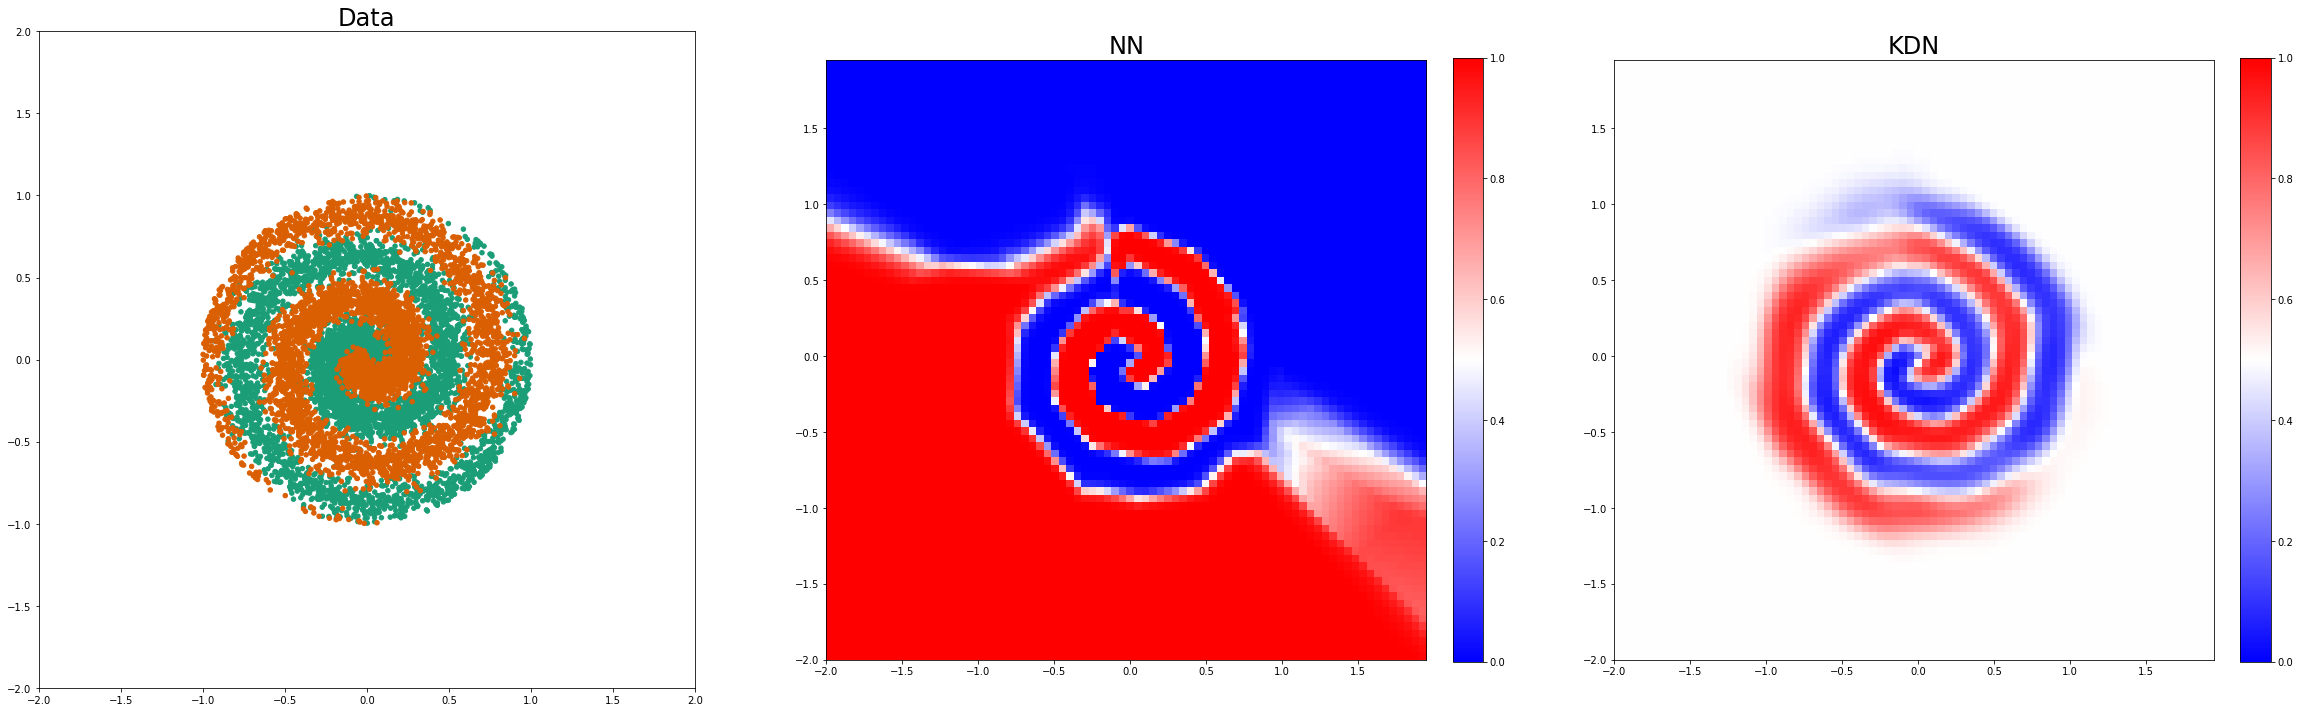

In [801]:
# plot

# define the grid
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

colors = sns.color_palette("Dark2", n_colors=2)
clr = [colors[i] for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=20)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    proba_nn[:, 0].reshape(80, 80).T,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    proba_kdn[:, 0].reshape(80, 80).T,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()


In [812]:
# create training, validation, and testing data
X, y = generate_ellipse(10000)

X_val, y_val = generate_ellipse(500)

X_test, y_test = generate_ellipse(1000)

In [813]:
# Define NN parameters
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=True)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [814]:
# define the network architecture
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(5, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [815]:
# train Vanilla NN
nn = getNN()
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Epoch 00047: early stopping


In [816]:
model_kdn = kdn(
    network=nn,
    polytope_compute_method='all',
    weighting_method='lin',
    k=1e-5,
    c=1, 
    verbose=False
)
model_kdn.fit(X, y)

In [817]:
print(
    np.mean(model_kdn.predict(X_test)==y_test)
)

0.917


In [818]:
print(
    np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
)

0.917


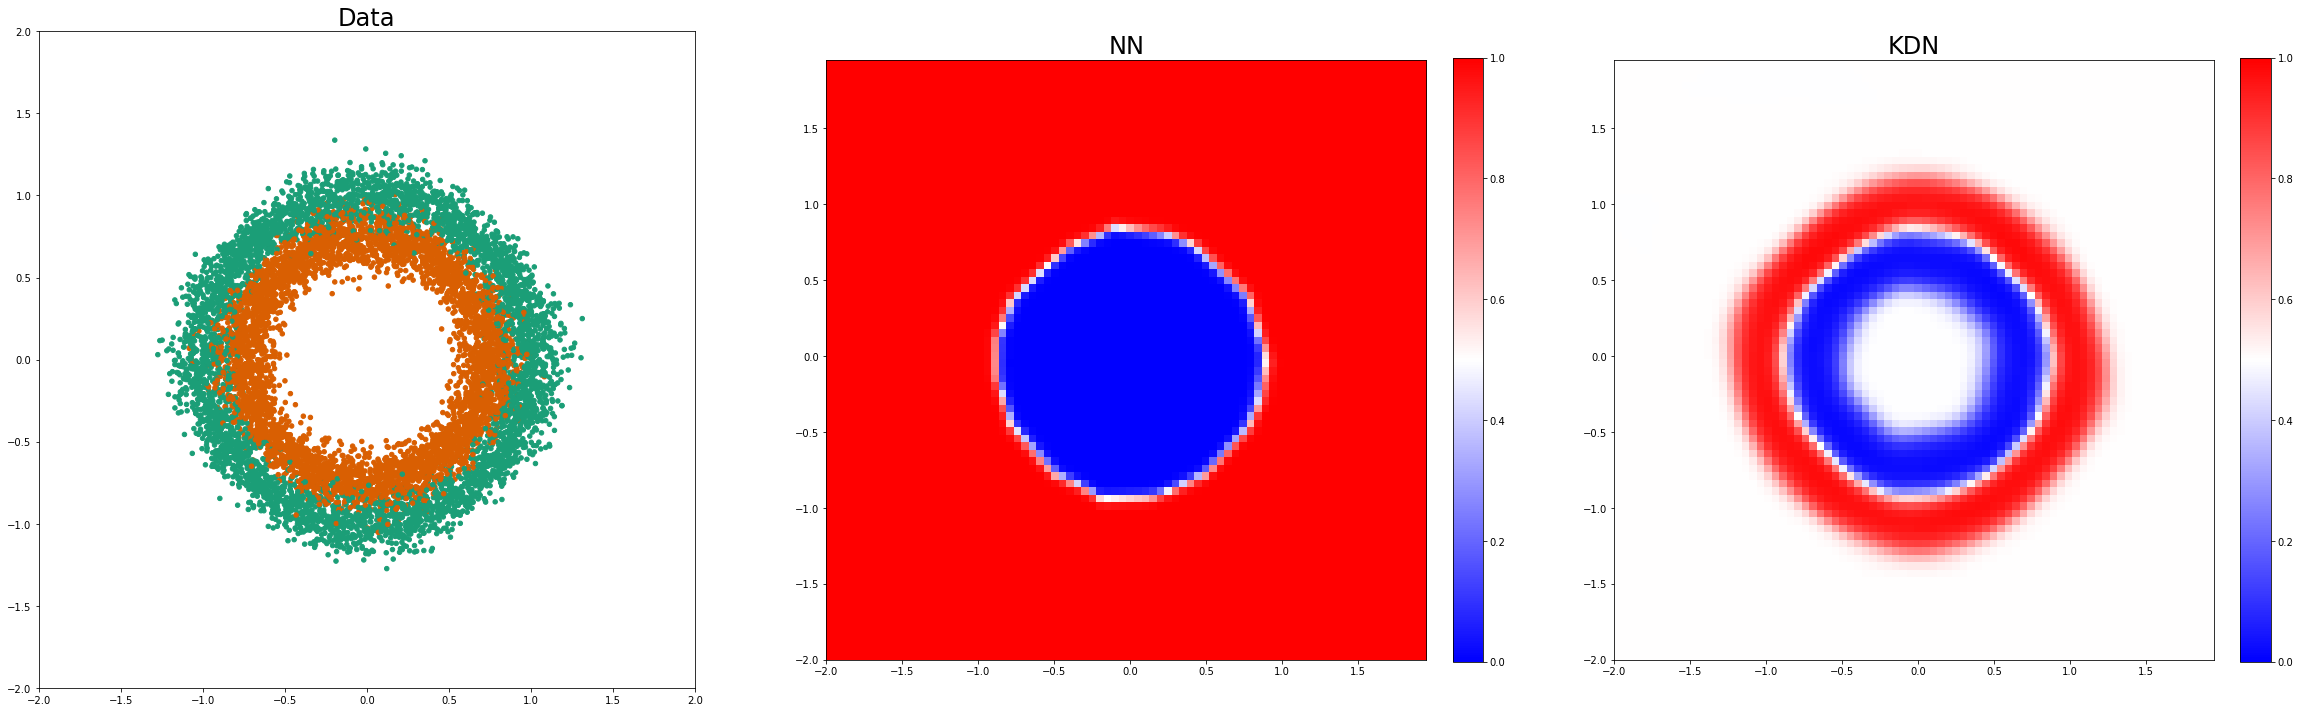

In [819]:
# plot

# define the grid
p = np.arange(-2, 2, step=0.05)
q = np.arange(-2, 2, step=0.05)
xx, yy = np.meshgrid(p, q)
tmp = np.ones(xx.shape)
grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

# plot
proba_kdn = model_kdn.predict_proba(grid_samples)
proba_nn = model_kdn.predict_proba_nn(grid_samples)

fig, ax = plt.subplots(1, 3, figsize=(40, 40))

colors = sns.color_palette("Dark2", n_colors=2)
clr = [colors[i] for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=20)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
ax[0].set_title("Data", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    proba_nn[:, 0].reshape(80, 80).T,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("NN", fontsize=24)
ax[1].set_aspect("equal")
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)

ax2 = ax[2].imshow(
    proba_kdn[:, 0].reshape(80, 80).T,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN", fontsize=24)
ax[2].set_aspect("equal")
fig.colorbar(ax2, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()


In [603]:
# get the weights and biases of the trained MLP
weights = {}
biases = {}
for i in range(len(nn.layers)):
    weight, bias = nn.layers[i].get_weights()
    weights[i], biases[i] = weight, bias.reshape(1, -1)

In [394]:
def compute_weights(X_, polytope_id, X_ref, polytope_ids):
    """compute weights based on the global network linearity measure

    Parameters
    ----------
    X_ : ndarray
        Input data matrix
    polytope_id : int
        refernce polytope identifier

    Returns
    -------
    ndarray
        weights of each input sample in the input data matrix
    """
    
    M_ref = model_kdn._get_activation_pattern(polytope_id)

    # A = np.empty((X_.shape[0], 0))
    # A_ref = np.empty((X_.shape[0], 0))
    start = 0
    for l in range(len(model_kdn.network_shape)-2):
        if l == 0:
            W = weights[l]
            B = biases[l]
            # A = np.hstack((A, model_kdn.unit_step(X_ @ W + B)))
            # A_ref = np.hstack((A_ref, X_ @ W + B))
        else:
            end = start + model_kdn.network_shape[l - 1]
            M_l = M_ref[start:end]
            start = end
            W = W @ np.diag(M_l) @ weights[l]
            B = B @ np.diag(M_l) @ weights[l] + biases[l]
            # A = np.hstack((A, model_kdn.unit_step(X_ @ W + B)))
            # A_ref = np.hstack((A_ref, X_ @ W + B))

    A_ref = model_kdn.unit_step(X_ref @ W + B)
    A = model_kdn.unit_step(X_ @ W + B)

    scales = np.exp(-np.linalg.norm(A - A_ref, axis=1, ord=1)**2)

    return scales

In [743]:
# def compute_weights(X_, polytope_id):
#     """compute weights based on the global network linearity measure

#     Parameters
#     ----------
#     X_ : ndarray
#         Input data matrix
#     polytope_id : int
#         refernce polytope identifier

#     Returns
#     -------
#     ndarray
#         weights of each input sample in the input data matrix
#     """
    
#     M_ref = model_kdn._get_activation_pattern(polytope_id)

#     M = np.empty((X_.shape[0], 0))
#     start = 0
#     activation = X_
#     for l in range(len(model_kdn.network_shape)-1):
#         end = start + model_kdn.network_shape[l]
#         M_l = M_ref[start:end]
#         start = end
#         W, B = weights[l], biases[l]
#         pre_activation = activation @ W + B
#         M = np.hstack((M, model_kdn.unit_step(pre_activation)))
#         activation = pre_activation @ np.diag(M_l)
#         activation = np.maximum(0, activation)

#     return np.exp(-np.linalg.norm(M - M_ref, axis=1, ord=1))

In [780]:
def compute_weights(X_, polytope_id):
    """compute weights based on the global network linearity measure

    Parameters
    ----------
    X_ : ndarray
        Input data matrix
    polytope_id : int
        refernce polytope identifier

    Returns
    -------
    ndarray
        weights of each input sample in the input data matrix
    """
    
    M_ref = model_kdn._get_activation_pattern(polytope_id)

    M = np.empty((X_.shape[0], 0))
    start = 0
    A = X_
    A_ref = X_
    d = 0
    for l in range(len(model_kdn.network_shape)-1):
        end = start + model_kdn.network_shape[l]
        M_l = M_ref[start:end]
        start = end
        W, B = weights[l], biases[l]
        pre_A = A @ W + B
        A = np.maximum(0, pre_A)
        pre_A_ref = A_ref @ W + B
        A_ref = pre_A_ref @ np.diag(M_l) 
        d += np.linalg.norm(A - A_ref, axis=1, ord=2)

    # return 1/( 1 + np.linalg.norm(A - A_ref, axis=1, ord=1))
    # scales = np.exp(-5*np.linalg.norm(A - A_ref, axis=1, ord=2))
    scales = np.exp(-d)
    return scales

In [768]:
model_kdn = kdn(
    network=nn,
    polytope_compute_method='all',
    verbose=False,
)
X_ = X[y==1]
polytope_ids = model_kdn._get_polytope_memberships(X_)[0]

Text(0.5, 1.0, 'Neighbor Polytopes')

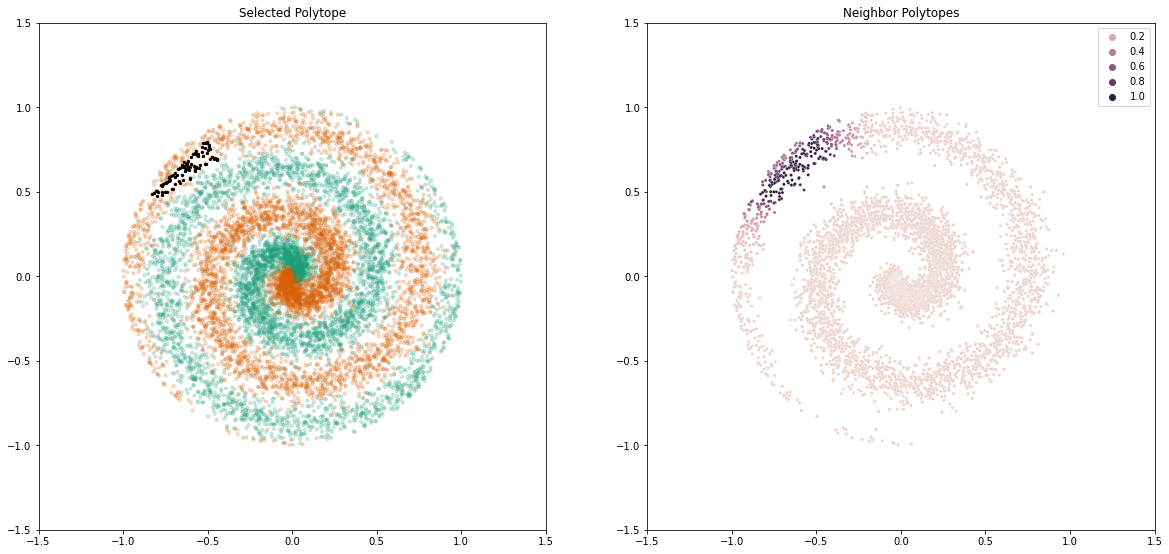

In [796]:
idx = np.random.randint(0, len(X_))
X_ref = X_[idx]
polytope_id = polytope_ids[idx]
P_ = X_[polytope_ids == polytope_id]
scales = compute_weights(X_, polytope_id)
# scales[scales != 1] = 0

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

colors = sns.color_palette("Dark2", n_colors=2)
clr = [colors[i] for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=10, alpha=0.2)
ax[0].scatter(P_[:, 0], P_[:, 1], c="k", s=5, alpha=1)
ax[0].set_xlim([-1.5, 1.5])
ax[0].set_ylim([-1.5, 1.5])
ax[0].set_aspect("equal")
ax[0].set_title("Selected Polytope")

sns.scatterplot(x=X_[:, 0], y=X_[:, 1], hue=scales, ax=ax[1], s=10)
ax[1].set_xlim([-1.5, 1.5])
ax[1].set_ylim([-1.5, 1.5])
ax[1].legend()
ax[1].set_aspect("equal")
ax[1].set_title("Neighbor Polytopes")

In [758]:
unique_polytopes = np.unique(polytope_ids)
scales[np.where(polytope_ids == unique_polytopes[2])[0]]

array([0.01043187, 0.01536196, 0.01652076, 0.01416734, 0.01113953,
       0.00850702, 0.00797971, 0.01624291, 0.00772292, 0.00582432,
       0.01592976, 0.01130128, 0.00867176, 0.01078676, 0.00872632,
       0.01461738, 0.01465454, 0.00715488, 0.00589588, 0.00903039,
       0.01205569, 0.00931248, 0.00607664, 0.00549893, 0.01117534,
       0.00552567, 0.01081885, 0.00561746, 0.00538062, 0.00879818,
       0.01015864, 0.00729902, 0.00833586, 0.00882248, 0.00365511,
       0.00660002, 0.00500892, 0.00577176, 0.00671141, 0.00808175,
       0.00330958, 0.0036351 , 0.00272529, 0.00330179, 0.0105681 ,
       0.00503613, 0.00558076, 0.00478828, 0.00880508, 0.00291979,
       0.00522521, 0.00486159, 0.00399409, 0.00272847, 0.00379557,
       0.00609573, 0.0025021 , 0.00553957, 0.00267964, 0.00348008,
       0.00261399])

In [623]:
model_kdn = kdn(
    network=nn,
    verbose=False,
)
X_ = X[y==1]
polytope_ids = model_kdn._get_polytope_memberships(X_)[0]
unique_polytope_ids = np.unique(polytope_ids)

In [678]:
def compute_projection_matrix(polytope_id):    
    M_ref = model_kdn._get_activation_pattern(polytope_id)

    start = 0
    for l in range(len(model_kdn.network_shape)-1):
        if l == 0:
            W = weights[l]
            B = biases[l]
        else:
            end = start + model_kdn.network_shape[l - 1]
            M_l = M_ref[start:end]
            start = end
            W = W @ np.diag(M_l) @ weights[l]
            B = B @ np.diag(M_l) @ weights[l] + biases[l]
    # P = np.vstack((W, B))
    P = W
    return P

In [679]:
polytope_projection_matrices = {}
for polytope in unique_polytope_ids:
    polytope_projection_matrices[polytope] = compute_projection_matrix(polytope)

Text(0.5, 1.0, 'Neighbor Polytopes')

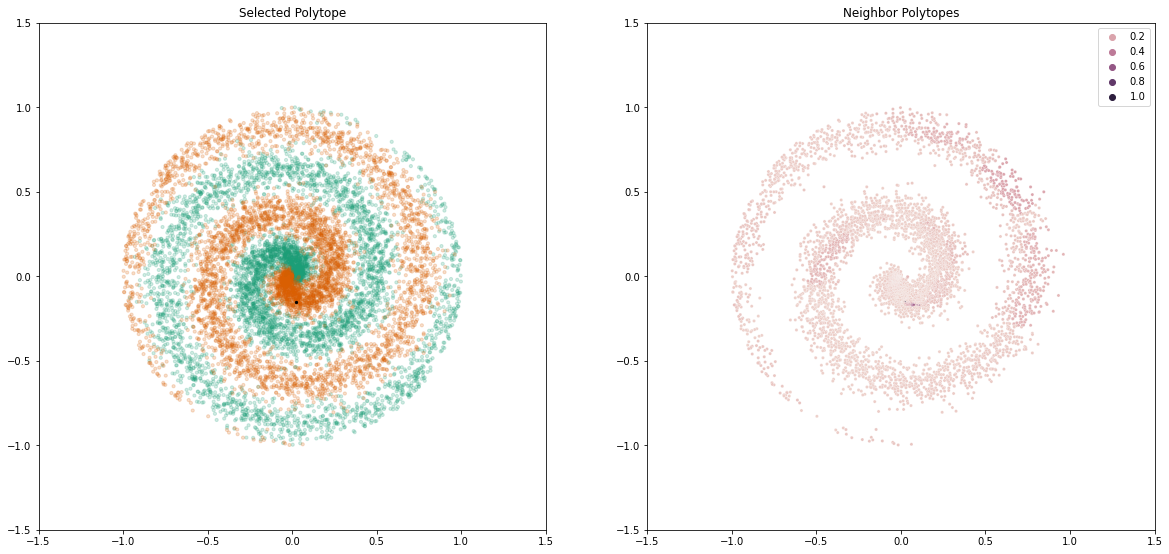

In [718]:
idx = np.random.randint(0, len(polytope_ids))
polytope_ref = polytope_ids[idx]
scales = []
for polytope in polytope_ids:
    d = np.linalg.norm( polytope_projection_matrices[polytope] - polytope_projection_matrices[polytope_ref], ord='fro')
    d = np.exp(-0.2*d)
    scales.append(d)
idxx = np.where(polytope_ids == polytope_ref)
P_ = X_[idxx]

fig, ax = plt.subplots(1, 2, figsize=(20, 20))

colors = sns.color_palette("Dark2", n_colors=2)
clr = [colors[i] for i in y]
ax[0].scatter(X[:, 0], X[:, 1], c=clr, s=10, alpha=0.2)
ax[0].scatter(P_[:, 0], P_[:, 1], c="k", s=5, alpha=1)
ax[0].set_xlim([-1.5, 1.5])
ax[0].set_ylim([-1.5, 1.5])
ax[0].set_aspect("equal")
ax[0].set_title("Selected Polytope")

sns.scatterplot(x=X_[:, 0], y=X_[:, 1], hue=scales, ax=ax[1], s=10)
ax[1].set_xlim([-1.5, 1.5])
ax[1].set_ylim([-1.5, 1.5])
ax[1].legend()
ax[1].set_aspect("equal")
ax[1].set_title("Neighbor Polytopes")

In [677]:
np.unique(scales)

array([6.28568797e-24, 5.22253620e-23, 7.79124729e-22, 1.34229603e-20,
       2.00846327e-20, 2.14022352e-20, 4.09553400e-20, 4.76351714e-20,
       5.74167128e-20, 2.87547189e-19, 6.98338539e-19, 8.77114122e-19,
       9.29283195e-19, 9.81767323e-19, 3.02452819e-18, 3.29044306e-18,
       4.20080155e-18, 5.17682239e-18, 6.01193781e-18, 2.14598640e-17,
       3.80974260e-16, 4.34537329e-16, 4.34737838e-16, 1.55246099e-15,
       1.73120000e-15, 1.92783748e-15, 1.95936117e-15, 2.11153204e-15,
       2.14042673e-15, 2.29153840e-15, 2.56020430e-15, 2.98510709e-15,
       3.45735743e-15, 3.67975728e-15, 4.36739404e-15, 4.41654805e-15,
       4.85469839e-15, 1.08995203e-14, 1.39605698e-14, 1.83370610e-14,
       1.84925042e-14, 2.08290186e-14, 2.21532968e-14, 2.83518889e-14,
       3.27292969e-14, 3.74217339e-14, 3.80896373e-14, 4.23829500e-14,
       4.49831811e-14, 6.27380994e-14, 8.17916072e-14, 8.20833147e-14,
       1.01541119e-13, 1.04854642e-13, 1.09374674e-13, 1.12298279e-13,
      

In [622]:
len(polytope_ids)

1